<a href="https://colab.research.google.com/github/ming-90/Kaggle_Study/blob/main/3.segmentation/nuclei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks/nuclei

/content/drive/MyDrive/Colab Notebooks/nuclei


In [ ]:
ls

nuclei.ipynb  stage1_test/  stage1_train/  stage1_train_labels.csv/


In [ ]:
import pathlib
import imageio
import numpy as np
import glob
traing_path = pathlib.Path('./stage1_train').glob('*/images/*.png')
training_sored = sorted([x for x in traing_path])
im_path = training_sored[45]
# 이미지 파일 읽기
im = imageio.imread(str(im_path))

In [ ]:
# origin image shape
print(im.shape)

from skimage.color import rgb2gray
im_gray = rgb2gray(im)

print(im_gray.shape)

(520, 696, 4)
(520, 696)


In [ ]:
from skimage.filters import threshold_otsu

#이진화 작업인듯
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask == 0) < np.sum(mask == 1):
    mask = np.where(mask, 0, 1)

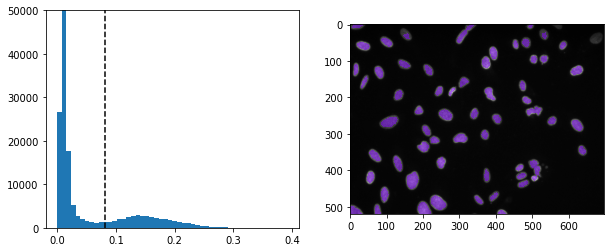

In [ ]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyles='--')
plt.ylim([0,50000])

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)

plt.show()

In [ ]:
from scipy import ndimage
# 이진화된 마스크에서 영역 찾아주는
labels, nlabels = ndimage.label(mask)

# 라벨별로 뭔가 해주는것같은데
# 라벨링 되어있는 데이터들을 이진화 시켜서 각각 저장
# 그래서 한개 사진이 라벨링 되어있는 갯수만큼 (여기서는 76개) 더 생김 
label_arrays = []
for label_num in range(1, nlabels + 1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

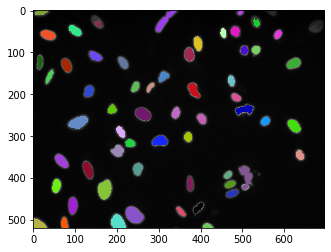

In [ ]:
from matplotlib.colors import ListedColormap 
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.show()

In [ ]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]

    if np.product(cell.shape) < 10:
        print( 'Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)
    
labels, nlabels = ndimage.label(mask)
print("There are now {} separate components / objects detectd.".format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detectd.


In [17]:
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

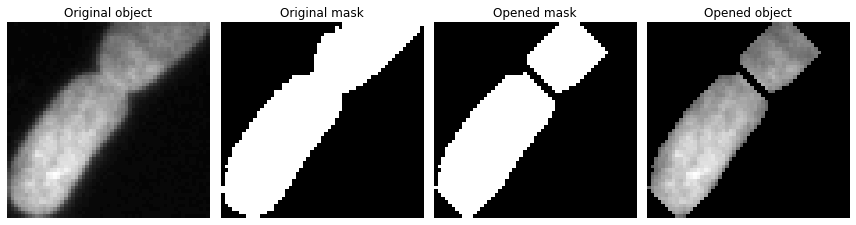

In [19]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [22]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2

    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1,0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print("RLE Encoding for the current mask is: {}".format(rle_encoding(mask)))

RLE Encoding for the current mask is: 496 25 527 3 1016 25 1044 7 1536 25 1563 10 2056 25 2083 11 2576 25 2602 12 3096 38 3616 39 4137 38 4290 9 4657 38 4799 23 5177 38 5312 31 5697 38 5830 34 6217 38 6348 36 6737 38 6868 36 7258 37 7387 37 7779 36 7907 37 8299 36 8375 3 8427 37 8819 36 8893 9 8947 36 9341 33 9411 13 9467 36 9862 32 9931 14 9988 33 10382 32 10450 16 10509 31 10903 31 10970 17 11030 29 11423 31 11489 19 11551 26 11944 30 12009 19 12073 22 12465 29 12528 21 12597 13 12985 29 13048 21 13506 28 13568 22 14027 26 14088 23 14213 2 14548 25 14607 24 14728 9 15068 25 15127 25 15245 13 15590 22 15647 25 15761 18 16111 20 16167 26 16279 21 16632 19 16687 26 16796 24 17154 16 17208 25 17314 26 17675 14 17728 25 17831 28 18197 12 18248 25 18350 28 18719 9 18768 26 18869 29 19241 4 19289 25 19387 30 19761 3 19809 25 19905 30 20281 3 20329 25 20424 30 20849 25 20943 30 21369 26 21463 28 21890 25 21982 28 22410 25 22502 26 22930 25 23021 25 23298 14 23451 23 23541 23 23814 20 23971 2

In [30]:
import pandas as pd

def analyze_image(im_path):
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)

    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
    labels, nlabels = ndimage.label(mask)

    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({"ImageId": im_id, "EncodedPixels": rle})
            im_df = im_df.append(s, ignore_index = True)
    return im_df

def analyze_list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    return all_df

In [38]:
testing = pathlib.Path('./stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)